# Figure 3: Do humans judge the unattested space as compositional?

In [1]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

# import seaborn_image as isns

sns.set_theme()

In [ ]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [ ]:
ratings = pd.read_csv("./simulate-comb-A-N/beh_stims_9907.csv")
ratings

,item,item_index,count,rt,age,trial_type,rating,adjective,noun
0,African catalog,17362,8,3491.375000,32.375000,crit,0.000000,African,catalog
1,African chance,4587,11,4111.181818,29.636364,crit,-1.090909,African,chance
2,African handset,9820,9,3138.666667,37.111111,crit,-0.666667,African,handset
3,African inception,2021,9,4961.000000,42.666667,crit,-0.111111,African,inception
4,African luxury,11633,8,3817.625000,33.375000,crit,2.125000,African,luxury
...,...,...,...,...,...,...,...,...,...
9902,young screw,257,9,3588.333333,41.333333,crit,-1.333333,young,screw
9903,young socket,14860,8,3872.375000,25.625000,crit,-1.875000,young,socket
9904,young spacecraft,5367,11,4878.000000,27.090909,crit,0.090909,young,spacecraft
9905,young taxi,3659,10,4184.800000,32.500000,crit,-1.700000,young,taxi


In [ ]:
adj_freq = pd.read_pickle("./simulate-comb-A-N/adj_freqs.pkl")
noun_freq = pd.read_pickle("./simulate-comb-A-N/noun_freqs.pkl")
pair_freq = pd.read_pickle("./simulate-comb-A-N/pair_freq.pkl")

In [ ]:
ratings["adj_freq"] = ratings["adjective"].apply(str.lower).map(adj_freq)
ratings["noun_freq"] = ratings["noun"].apply(str.lower).map(noun_freq)
ratings["pair_freq"] = ratings["item"].apply(str.lower).map(pair_freq)
ratings.fillna(0, inplace=True)

In [ ]:
ratings

,item,item_index,count,rt,age,trial_type,rating,adjective,noun,adj_freq,noun_freq,pair_freq
0,African catalog,17362,8,3491.375000,32.375000,crit,0.000000,African,catalog,42649.0,4895.0,0.0
1,African chance,4587,11,4111.181818,29.636364,crit,-1.090909,African,chance,42649.0,62750.0,0.0
2,African handset,9820,9,3138.666667,37.111111,crit,-0.666667,African,handset,42649.0,522.0,0.0
3,African inception,2021,9,4961.000000,42.666667,crit,-0.111111,African,inception,42649.0,1612.0,0.0
4,African luxury,11633,8,3817.625000,33.375000,crit,2.125000,African,luxury,42649.0,6061.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9902,young screw,257,9,3588.333333,41.333333,crit,-1.333333,young,screw,157344.0,2085.0,0.0
9903,young socket,14860,8,3872.375000,25.625000,crit,-1.875000,young,socket,157344.0,1939.0,0.0
9904,young spacecraft,5367,11,4878.000000,27.090909,crit,0.090909,young,spacecraft,157344.0,3977.0,0.0
9905,young taxi,3659,10,4184.800000,32.500000,crit,-1.700000,young,taxi,157344.0,4478.0,0.0


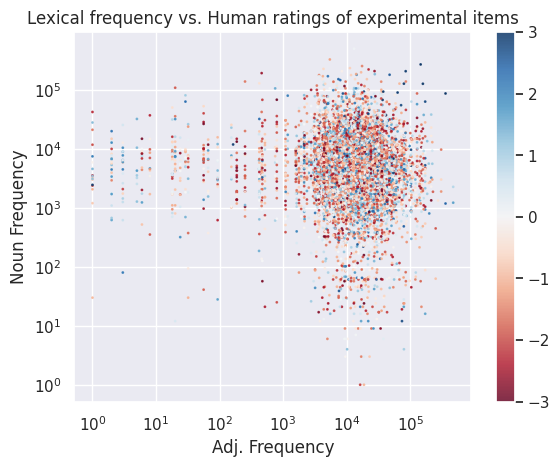

In [ ]:
plt.scatter(
    ratings["adj_freq"],
    ratings["noun_freq"],
    c=ratings["rating"],
    s=1,
    alpha=0.8,
    cmap="RdBu",
)
plt.colorbar()
plt.xlabel("Adj. Frequency")
plt.ylabel("Noun Frequency")
plt.xscale("log")
plt.yscale("log")
plt.title("Lexical frequency vs. Human ratings of experimental items")

plt.show()

In [55]:
def compute_fit(data, target="rating", metric="logp_N_A"):
    y = data["metadata", target]
    x = data["model", metric]
    model = sm.OLS(y, sm.add_constant(x))
    fit = model.fit()

    return fit, dict(
        b=fit.params[0], m=fit.params[1], p=fit.pvalues[1], r2=fit.rsquared
    )


def plot_fit(data, metric="logp_N_A"):
    model_name = data["metadata", "model"].iloc[0]

    fit, info = compute_fit(data, metric=metric)
    b, m = fit.params
    print(fit.summary())
    f, ax = plt.subplots(figsize=(7, 5))

    y = data["metadata", "rating"]
    x = data["model", metric]
    ax.scatter(x, y, alpha=0.5, s=1)
    # ax.set_yscale("log")
    # ax.set_yscale("log")
    # extract intercept b and slope m
    # plot y = m*x + b
    ax.axline(
        xy1=(0, b),
        # xy2=(10, 10 * m + b),
        color="r",
        linewidth=2,
        linestyle="-",
        slope=m,
        label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    )
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(1, max(y))
    ax.legend(loc="lower right", bbox_to_anchor=(1, 0))
    ax.set_title(f"{model_name} {metric} predict human ratings")
    ax.set_xlabel(model_name + " " + metric)
    ax.set_ylabel("human ratings")

    plt.tight_layout()
    plt.show()

                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.115
Model:                                OLS   Adj. R-squared:                  0.115
Method:                     Least Squares   F-statistic:                     1291.
Date:                    Fri, 19 Jan 2024   Prob (F-statistic):          6.48e-266
Time:                            11:28:45   Log-Likelihood:                -16526.
No. Observations:                    9907   AIC:                         3.306e+04
Df Residuals:                        9905   BIC:                         3.307e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


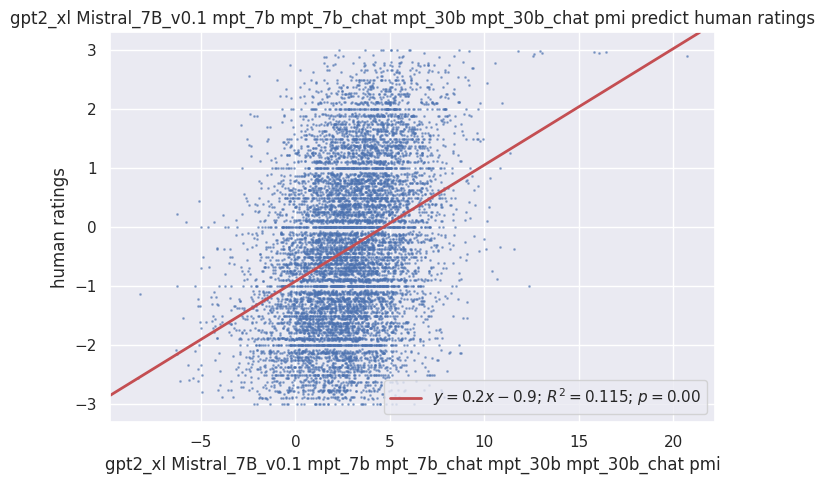

In [51]:
plot_fit(llm_agg, metric="pmi")

                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.058
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     606.4
Date:                    Fri, 19 Jan 2024   Prob (F-statistic):          5.33e-130
Time:                            11:28:51   Log-Likelihood:                -16839.
No. Observations:                    9907   AIC:                         3.368e+04
Df Residuals:                        9905   BIC:                         3.370e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

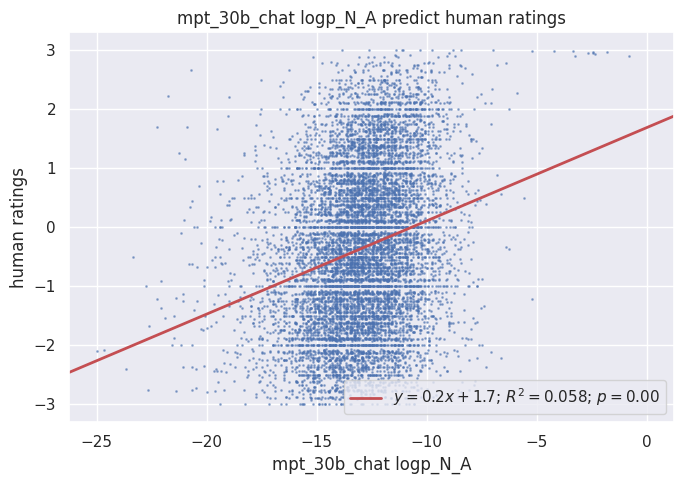

In [52]:
plot_fit(mpt_30b_chat, metric="logp_N_A")

                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.059
Method:                     Least Squares   F-statistic:                     627.4
Date:                    Fri, 19 Jan 2024   Prob (F-statistic):          2.57e-134
Time:                            11:27:37   Log-Likelihood:                -16829.
No. Observations:                    9907   AIC:                         3.366e+04
Df Residuals:                        9905   BIC:                         3.368e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

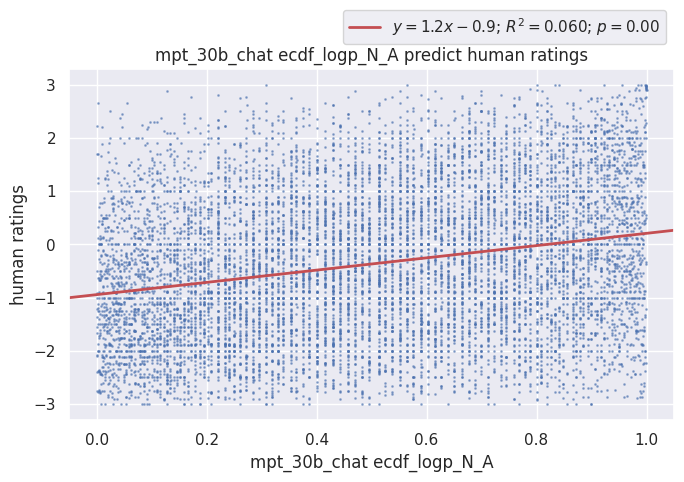

In [44]:
plot_fit(mpt_30b_chat, metric="ecdf_logp_N_A")

In [58]:
mistral7b

Mistral_7B_v0.1                                             metadata  \
       ecdf_logp_N_A     logp_A     logp_N   logp_N_A       pmi adjective   
0           0.185021 -10.365811 -14.635343 -14.795146 -0.230548   African   
1           0.496013 -10.365811 -11.365811 -12.938701 -2.269200   African   
2           0.680832 -10.365811 -18.886718 -12.033659  9.886875   African   
3           0.078026 -10.365811 -17.049145 -15.986868  1.532542   African   
4           0.838498 -10.365811 -13.994718 -11.021708  4.289145   African   
...              ...        ...        ...        ...       ...       ...   
9902        0.516503  -9.584561 -13.895352 -12.842947  1.518300     young   
9903        0.063591  -9.584561 -16.053312 -16.206839 -0.221492     young   
9904        0.563137  -9.584561 -15.296902 -12.623552  3.856829     young   
9905        0.821036  -9.584561 -13.150968 -11.159964  2.872412     young   
9906        0.505299  -9.584561 -13.441983 -12.902151  0.778813     young   

                                                                            
            age count     id        noun    rating           rt trial_type  
0     32.375000     8  17362     catalog  0.000000  3491.375000       crit  
1     29.636364    11   4587      chance -1.090909  4111.181818       crit  
2     37.111111     9   9820     handset -0.666667  3138.666667       crit  
3     42.666667     9   2021   inception -0.111111  4961.000000       crit  
4     33.375000     8  11633      luxury  2.125000  3817.625000       crit  
...         ...   ...    ...         ...       ...          ...        ...  
9902  41.333333     9    257       screw -1.333333  3588.333333       crit  
9903  25.625000     8  14860      socket -1.875000  3872.375000       crit  
9904  27.090909    11   5367  spacecraft  0.090909  4878.000000       crit  
9905  32.500000    10   3659        taxi -1.700000  4184.800000       crit  
9906  29.333333     9   8962     tobacco  0.222222  6871.000000       crit  

[9907 rows x 13 columns]

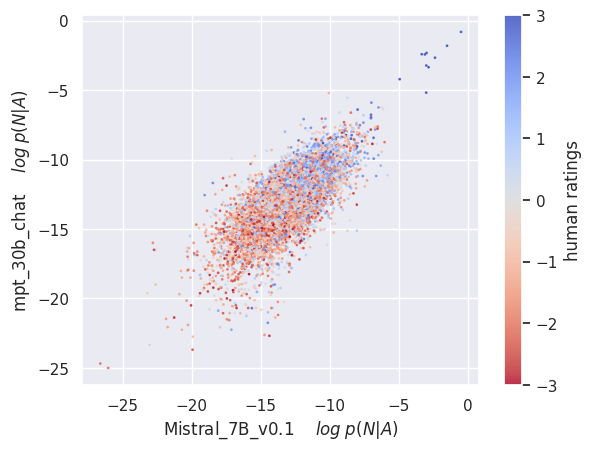

In [74]:
plt.scatter(
    x=mistral7b["model", "logp_N_A"],
    y=mpt_30b_chat["model", "logp_N_A"],
    s=1,
    alpha=0.8,
    cmap="coolwarm_r",
    c=mpt30b["metadata", "rating"],
)
plt.xlabel("Mistral_7B_v0.1 $\quad log\;p(N|A)$")
plt.ylabel("mpt_30b_chat $\quad log\;p(N|A)$")
plt.colorbar(
    label="human ratings",
)
plt.show()

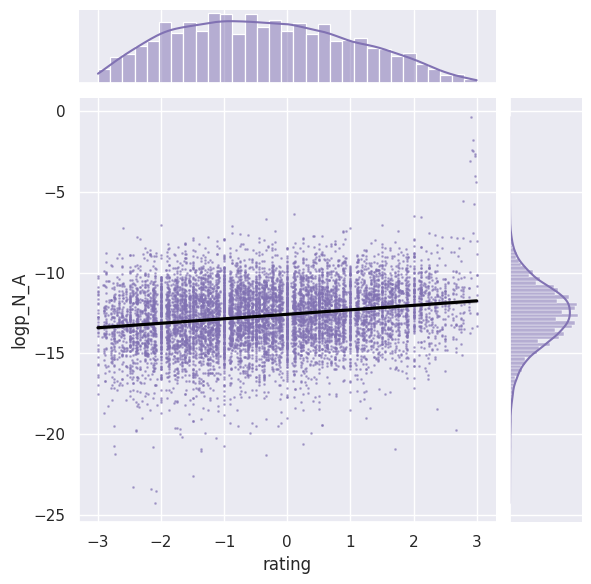

In [128]:
sns.jointplot(
    data=gptlogp,
    y="logp_N_A",
    x="rating",
    kind="reg",
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "black"},
    color="m",
    ci=99,
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
)

In [98]:
gptlogpall = get_results(study="composlang", model="gpt2_xl", paradigm="logprobs")
gptlogpall = gptlogpall[(gptlogpall["arank"] >= 0) & (gptlogpall["nrank"] >= 0)]

In [99]:
phi2logpall = get_results(study="composlang", model="phi_2", paradigm="logprobs")
phi2logpall = phi2logpall[(phi2logpall["arank"] >= 0) & (phi2logpall["nrank"] >= 0)]

<AxesSubplot:xlabel='nrank', ylabel='arank'>

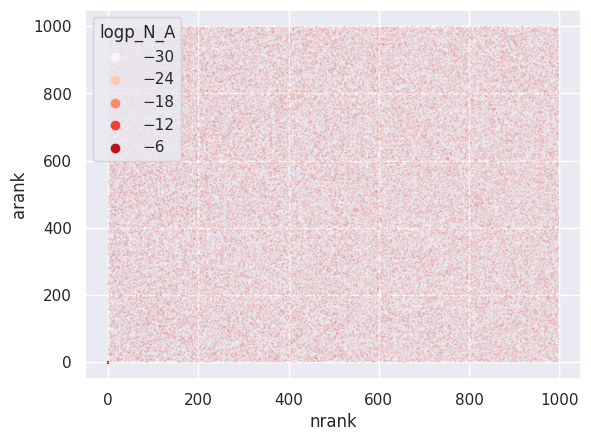

In [8]:
sns.scatterplot(
    data=mpt7bchat.sample(100_000),
    x="nrank",
    y="arank",
    hue="logp_N_A",
    edgecolor=None,
    s=1,
    alpha=0.1,
    palette="Reds",
)

In [100]:
view = pd.merge(gptlogpall, phi2logpall, on=["id"])

In [103]:
view.sample(10)

,adjective_x,noun_x,arank_x,nrank_x,logp_N_A_x,adjective_y,noun_y,arank_y,nrank_y,logp_N_A_y
id,,,,,,,,,,
643637,harsh,streets,643,637,-11.1875,harsh,streets,643,637,-11.912045
537704,behavioral,hell,537,704,-10.3750,behavioral,hell,537,704,-13.732407
551745,lowest,truck,551,745,-11.8125,lowest,truck,551,745,-10.664518
566587,islamic,investigation,566,587,-11.8125,islamic,investigation,566,587,-12.811707
508967,joint,authorities,508,967,-9.7500,joint,authorities,508,967,-9.600072
42049,whole,side,42,49,-9.6875,whole,side,42,49,-8.653444
750998,unprecedented,exchange,750,998,-9.5000,unprecedented,exchange,750,998,-10.237356
2183,new,summer,2,183,-9.1875,new,summer,2,183,-11.083316
691020,tribal,work,691,20,-8.9375,tribal,work,691,20,-8.869001


<AxesSubplot:xlabel='logp_N_A_x', ylabel='logp_N_A_y'>

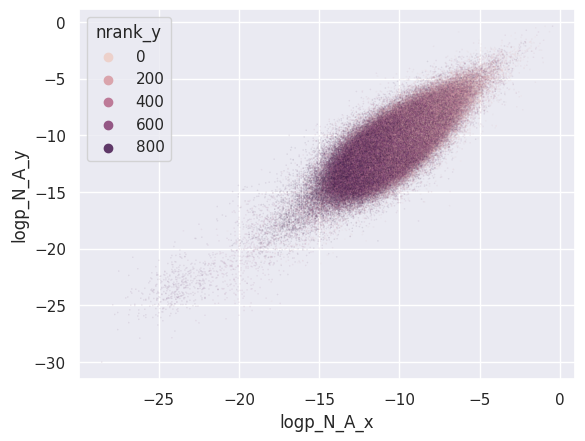

In [106]:
sns.scatterplot(
    data=view.sample(500_000),
    x="logp_N_A_x",
    y="logp_N_A_y",
    hue="nrank_y",
    edgecolor=None,
    s=1,
    alpha=0.1,
    # palette="Reds",
)

<AxesSubplot:xlabel='logp_N_A', ylabel='logp_N'>

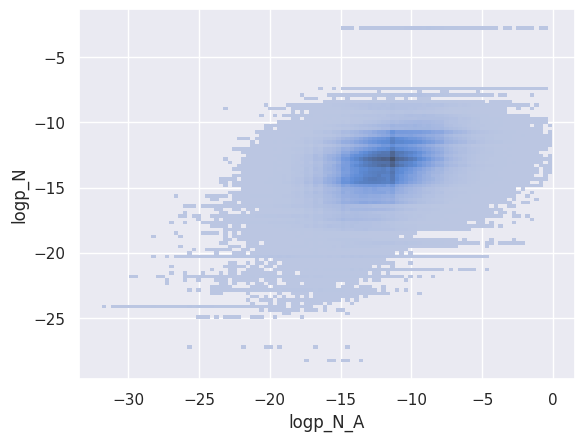

In [19]:
sns.histplot(
    data=mpt7bchat,
    x="logp_N_A",
    y="logp_N",
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
    # alpha=0.1,
    bins=100,
)

In [134]:
gptlogp.apply(lambda x: x["logp_N_A"] - x["logp_N"], axis=1)

0       2.5625
1       5.6875
2       3.1250
3       2.5000
4       3.3750
         ...  
9902    2.5625
9903    4.5000
9904    4.0625
9905    4.8125
9906    6.4375
Length: 9907, dtype: float64